In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models
import models_3d_concepts_on_time
import models_3d_atomics_on_variate_to_concepts
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

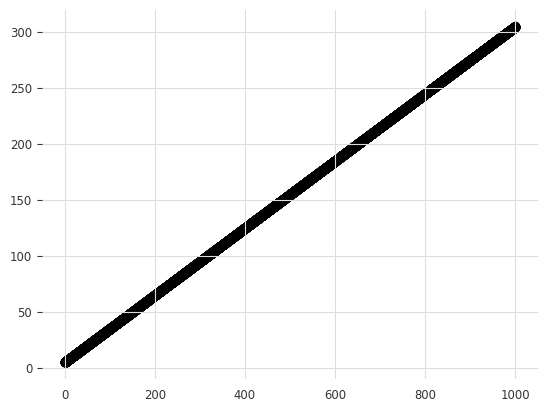

In [2]:

def line(x, w=0.3, b=5):
    return w*x + b

time = np.linspace(0, 1000, 10000).reshape(-1,1)

line_series = [line(x) for x in time]
line_series = np.array(line_series).reshape(-1,1)

plt.scatter(time, line_series)
plt.show()

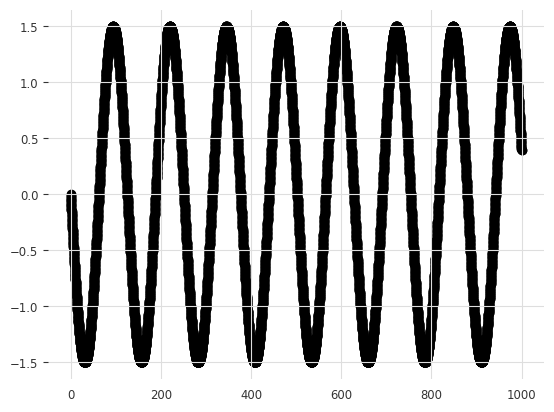

In [3]:

def sine_wave(time, frequency = 1, amplitude = 1, phase = 0):
    return amplitude * np.sin(frequency * time + phase)

sine_series = sine_wave(time, frequency = 0.05, amplitude = 1.5, phase = np.pi)

plt.scatter(time, sine_series)
plt.show()

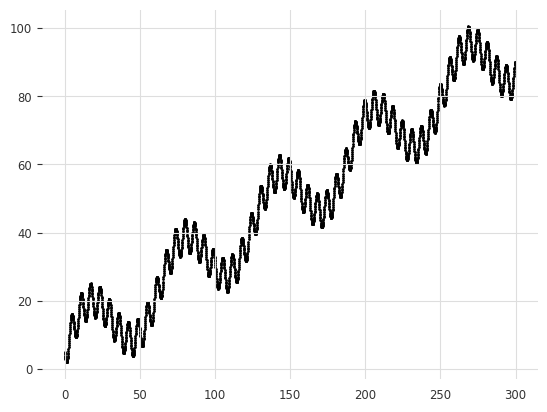

In [4]:

components_series = sine_wave(time, frequency = 1, amplitude = 5, phase = np.pi) \
                + sine_wave(time, frequency = 0.1, amplitude = 10, phase = 0) \
                + line_series

plt.scatter(time[:3000], components_series[:3000], s=1)
plt.show()

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [6]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train_end = int(len(series) * 0.6)
    val_end = int(train_end + len(series) * 0.2)
    
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]
    
    # train, test = series.split_before(0.6)
    # val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train = scaler.fit_transform(train)
    X_train = pd.DataFrame(train)
    y_train = X_train
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val = scaler.transform(val)
    X_val = pd.DataFrame(val)
    y_val = X_val
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test = scaler.transform(test)
    X_test = pd.DataFrame(test)
    y_test = X_test
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


Train/Val/Test 6000 2000 2000
torch.Size([512, 100, 2]) False
torch.Size([512, 10]) False


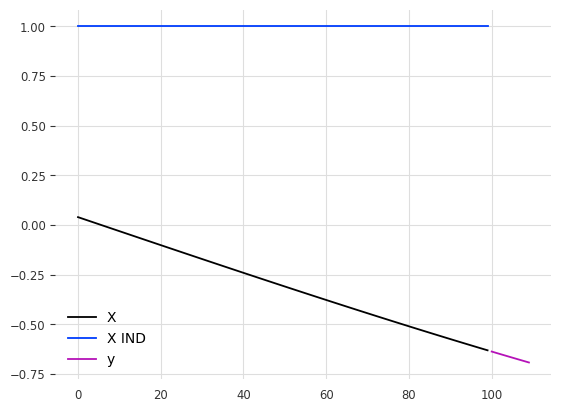

Batches 12 4 4


In [7]:
seq_len = 100
pred_len = 10

train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

for X,y in train_loader:
    print(X.shape, X.requires_grad)
    print(y.shape, X.requires_grad)
    break

i = 0
plt.plot(range(seq_len), X[i, :, 0], label="X")
plt.plot(range(seq_len), X[i, :, 1], label="X IND")
plt.plot(range(seq_len, seq_len + pred_len), y[i], label="y")
plt.legend()
plt.show()


print("Batches", len(train_loader), len(val_loader), len(test_loader))


In [8]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(Xb, yb, preds, title):
    x = list(range(len(Xb)))
    xx = list(range(len(Xb), len(Xb)+len(yb)))
    plt.plot(x, Xb, color="black", label="True X")
    plt.plot(xx, yb, color="blue", label="True y")
    plt.plot(xx, preds, color="red", label="Pred y")
    plt.title(title)
    plt.legend()
    plt.show()


In [9]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, top_k=''):
    model = models_3d_atomics_on_variate_to_concepts.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics = n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_3d_atomics_on_variate_to_concepts.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [10]:
random_seed = 1
set_seed(random_seed)


In [11]:
seq_len = 100
pred_len = 10
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = 1 #len(series.columns)
input_dim = 2 * changing_dim


## Blaaa

In [12]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/debug/debugging-L{seq_len}-T{pred_len}/"
# model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 6000 2000 2000
cutoff_times before Parameter containing:
tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)
lower_thresholds before Parameter containing:
tensor([-0.5830], device='cuda:0', dtype=torch.float64, requires_grad=True)
upper_thresholds before Parameter containing:
tensor([0.7203], device='cuda:0', dtype=torch.float64, requires_grad=True)


 19%|█▊        | 1859/10000 [09:09<40:07,  3.38it/s]

Early Stopped
cutoff_times after Parameter containing:
tensor([[  2.1385e-04,  -1.8834e-04,   8.4696e-15,   2.6070e-12, -3.2503e-318,
           2.4943e-15,  -6.5439e-11,  -7.5862e-04,  -1.9698e-03]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)
lower_thresholds after Parameter containing:
tensor([-1.1510], device='cuda:0', dtype=torch.float64, requires_grad=True)
upper_thresholds after Parameter containing:
tensor([1.4050], device='cuda:0', dtype=torch.float64, requires_grad=True)


MSE 0.001383256632834673 MAE 0.026067718863487244
(10, 1)
(10, 1)


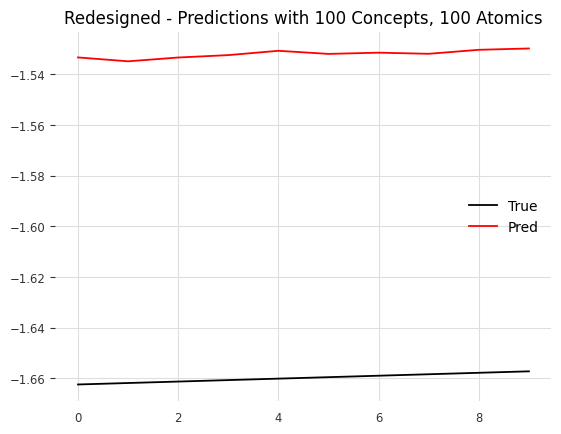

,0
-1.533268,-1.662480
-1.534800,-1.661903
-1.533297,-1.661325
-1.532348,-1.660748
-1.530644,-1.660171
-1.531871,-1.659593
-1.531386,-1.659016
-1.531831,-1.658439
-1.530256,-1.657861
-1.529729,-1.657284


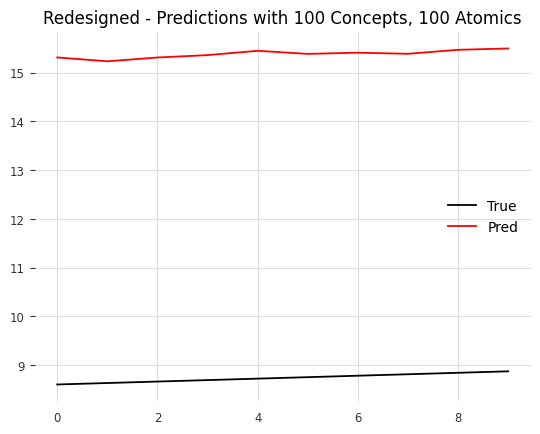

,0
15.315090,8.600361
15.235485,8.630360
15.313595,8.660366
15.362904,8.690365
15.451435,8.720371
15.387707,8.750378
15.412868,8.780376
15.389790,8.810383
15.471615,8.840382
15.498981,8.870388


In [13]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(line_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

print("cutoff_times before", model.cutoff_percentage)
print("lower_thresholds before", model.lower_thresholds)
print("upper_thresholds before", model.upper_thresholds)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("line"), max_epochs=10000, scheduler=scheduler, patience=100)

print("cutoff_times after", model.cutoff_percentage)
print("lower_thresholds after", model.lower_thresholds)
print("upper_thresholds after", model.upper_thresholds)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


Train/Val/Test 6000 2000 2000


100%|██████████| 10000/10000 [49:36<00:00,  3.36it/s]


MSE 0.00015096001152414829 MAE 0.00903109461069107
(10, 1)
(10, 1)


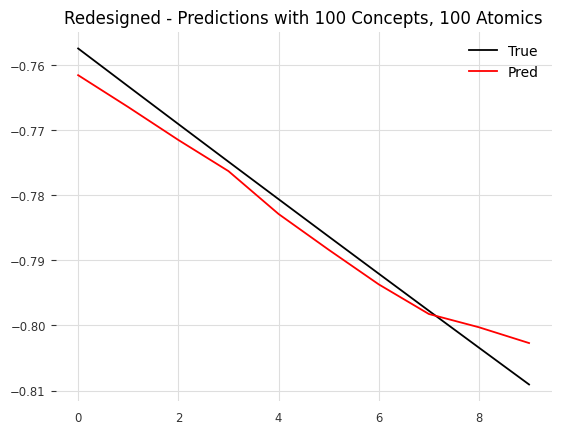

,0
-0.761559,-0.757457
-0.766458,-0.763274
-0.771512,-0.769070
-0.776294,-0.774846
-0.782879,-0.780602
-0.788371,-0.786337
-0.793693,-0.792052
-0.798243,-0.797745
-0.800281,-0.803418
-0.802707,-0.809070


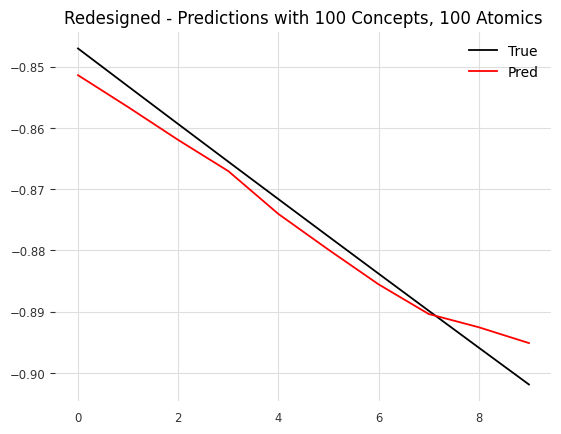

,0
-0.851396,-0.847038
-0.856600,-0.853218
-0.861970,-0.859376
-0.867051,-0.865513
-0.874047,-0.871628
-0.879883,-0.877722
-0.885537,-0.883793
-0.890372,-0.889843
-0.892537,-0.895870
-0.895115,-0.901875


In [14]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("sine"), max_epochs=10000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break

i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


Train/Val/Test 6000 2000 2000


 24%|██▎       | 2369/10000 [11:47<37:58,  3.35it/s]

Early Stopped


MSE 0.0015530562959611416 MAE 0.02958284690976143
(10, 1)
(10, 1)


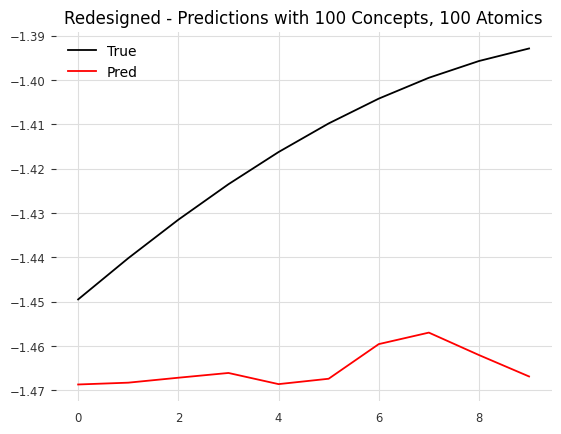

,0
-1.468660,-1.449469
-1.468252,-1.440170
-1.467135,-1.431483
-1.466062,-1.423478
-1.468580,-1.416220
-1.467367,-1.409766
-1.459553,-1.404166
-1.456957,-1.399460
-1.462018,-1.395681
-1.466851,-1.392852


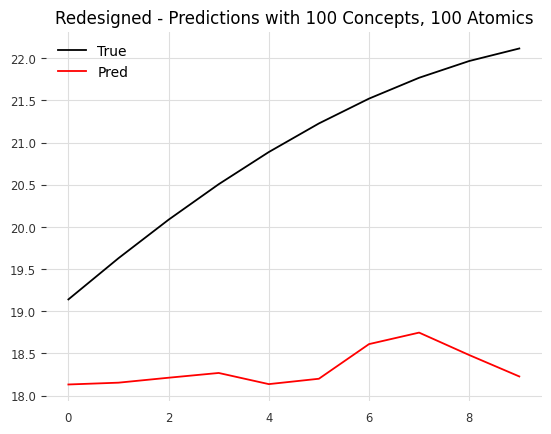

,0
18.131449,19.139849
18.152864,19.628450
18.211550,20.084932
18.267946,20.505556
18.135660,20.886927
18.199396,21.226046
18.609964,21.520311
18.746393,21.767572
18.480440,21.966135
18.226519,22.114794


In [15]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=50)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("components_series"), max_epochs=10000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

print(model)
# print(model.named_parameters)

# for name, param in model.named_parameters():
#     print(name, param.shape, param.requires_grad, param.device, param.dtype)
#     if param.grad is not None:
#         print(f"Parameter: {name}, Gradient: {param}")


model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=100, patience=100, show_grad=True)
